<a href="https://colab.research.google.com/github/wassimchouchen/Automatic-Speech-Recognition-/blob/main/Identify_medical_vocabulary(wordcloud).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install -q git+https://github.com/openai/whisper.git > /dev/null
!pip install -q git+https://github.com/pyannote/pyannote-audio > /dev/null
!pip install pydub
import whisper
import datetime

import subprocess

import torch
import pyannote.audio
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding
embedding_model = PretrainedSpeakerEmbedding( 
    "speechbrain/spkrec-ecapa-voxceleb",
    device=torch.device("cuda"))

from pyannote.audio import Audio
from pyannote.core import Segment

import wave
import contextlib
import pydub

from sklearn.cluster import AgglomerativeClustering
import numpy as np
import torch

# Check if a GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
num_speakers = 2 
language = 'any' 
model_size = 'medium'

In [3]:
# upload audio file
from google.colab import files
uploaded = files.upload()
path = next(iter(uploaded))

Saving conv.mp3 to conv.mp3


In [4]:
if path[-3:] != 'wav':
  subprocess.call(['ffmpeg', '-i', path, 'audio.wav', '-y'])
  path = 'audio.wav'
# Load the audio file
audio_file = pydub.AudioSegment.from_wav(path)
audio_file = audio_file.set_channels(1)
audio_file.export(path, format="wav")
with wave.open(path) as f:
  print(f.getnchannels())

1


In [5]:
model = whisper.load_model(model_size)

100%|█████████████████████████████████████| 1.42G/1.42G [00:16<00:00, 90.9MiB/s]


In [6]:
result = model.transcribe(path)
segments = result["segments"]

In [7]:
text=result["text"]

In [8]:
text

" podcastfrancaisfacile.com Bonjour. Bonjour, installez-vous, je vous en prie. Merci. Alors, qu'est-ce qui vous amène ? Eh bien, j'ai des douleurs au ventre, au niveau de l'estomac. Vous avez mal à l'estomac ? En fait, je ne suis pas sûr que ce soit à l'estomac. Vous avez mal en permanence ? Non, ce n'est pas tout le temps, c'est surtout après manger. Comment est la douleur ? Ce n'était pas très fort au début, mais depuis quelques jours, c'est très aigu. Quand ont commencé les premières douleurs ? C'était il y a deux mois environ. Je pensais que ça passerait, mais finalement, c'est de pire en pire. Bien, on va regarder ça. Enlevez votre chemise et allongez-vous."

In [9]:
!pip install -U transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.8 MB/s eta 0:00:00


In [10]:
candidate_labels = ['anatomie', 'pelvien', "périnée", "vagin", "vaginal", "anus", "rectal",
"rectum", "utérus", "utérin", "urètre", "cavité", "endocavitaire" , "examens", "touché vaginale", 
"touché mammaire", "touché abdominal", "touché rectale", "échographie", "frottis", "prélèvement" ,
"instruments médicaux","speculum", "sondes", "gants", "lubrifiant" , "pathologies" , "HPV", "IST", "MST", "incontinence",
"endométriose", "douleur", "périnéale"]


In [11]:
from nltk.corpus import stopwords
import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")
lemmatizer = WordNetLemmatizer()
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
import matplotlib.style as stl 
stl.use('ggplot')
nltk.download('stopwords')
import string
punct='!"#$%&\'()*+-/<=>?@[\\]^`{|}~'
# Create a set of French stop words
stop_words = set(stopwords.words('french'))
import nltk
nltk.download('punkt')
punctuation = string.punctuation
def process(s):
    for p in punct:
        s = s.replace(p, '')
    s = word_tokenize(s)
    s = [w for w in s if not w in stop_words]
    return s

processed_text = process(text)
processed_text = " ".join(processed_text)

print(processed_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


podcastfrancaisfacile.com Bonjour . Bonjour , installezvous , prie . Merci . Alors , questce amène Eh bien , jai douleurs ventre , niveau lestomac . Vous mal lestomac En fait , sûr lestomac . Vous mal permanence Non , nest tout temps , cest surtout après manger . Comment douleur Ce nétait très fort début , depuis quelques jours , cest très aigu . Quand commencé premières douleurs Cétait a deux mois environ . Je pensais ça passerait , finalement , cest pire pire . Bien , va regarder ça . Enlevez chemise allongezvous .


In [12]:
processed_text

'podcastfrancaisfacile.com Bonjour . Bonjour , installezvous , prie . Merci . Alors , questce amène Eh bien , jai douleurs ventre , niveau lestomac . Vous mal lestomac En fait , sûr lestomac . Vous mal permanence Non , nest tout temps , cest surtout après manger . Comment douleur Ce nétait très fort début , depuis quelques jours , cest très aigu . Quand commencé premières douleurs Cétait a deux mois environ . Je pensais ça passerait , finalement , cest pire pire . Bien , va regarder ça . Enlevez chemise allongezvous .'

In [13]:
text

" podcastfrancaisfacile.com Bonjour. Bonjour, installez-vous, je vous en prie. Merci. Alors, qu'est-ce qui vous amène ? Eh bien, j'ai des douleurs au ventre, au niveau de l'estomac. Vous avez mal à l'estomac ? En fait, je ne suis pas sûr que ce soit à l'estomac. Vous avez mal en permanence ? Non, ce n'est pas tout le temps, c'est surtout après manger. Comment est la douleur ? Ce n'était pas très fort au début, mais depuis quelques jours, c'est très aigu. Quand ont commencé les premières douleurs ? C'était il y a deux mois environ. Je pensais que ça passerait, mais finalement, c'est de pire en pire. Bien, on va regarder ça. Enlevez votre chemise et allongez-vous."

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
vectorizer = TfidfVectorizer()
texts = [processed_text]  # Create a list with the processed text as a single element
tfidf_data = vectorizer.fit_transform(texts).toarray()
tfidf_features = vectorizer.get_feature_names_out()
tfidf_data = pd.DataFrame(tfidf_data, columns=tfidf_features)


In [15]:
tfidf_features

array(['aigu', 'allongezvous', 'alors', 'amène', 'après', 'bien',
       'bonjour', 'ce', 'cest', 'chemise', 'com', 'commencé', 'comment',
       'cétait', 'depuis', 'deux', 'douleur', 'douleurs', 'début', 'eh',
       'en', 'enlevez', 'environ', 'fait', 'finalement', 'fort',
       'installezvous', 'jai', 'je', 'jours', 'lestomac', 'mal', 'manger',
       'merci', 'mois', 'nest', 'niveau', 'non', 'nétait', 'passerait',
       'pensais', 'permanence', 'pire', 'podcastfrancaisfacile',
       'premières', 'prie', 'quand', 'quelques', 'questce', 'regarder',
       'surtout', 'sûr', 'temps', 'tout', 'très', 'va', 'ventre', 'vous',
       'ça'], dtype=object)

In [16]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=1)
mat = lda.fit_transform(tfidf_data)
mat.shape

(1, 1)

In [17]:
topic_word = lda.components_
topic_word.shape

(1, 59)

In [18]:
from wordcloud import WordCloud, STOPWORDS
def wordcloud(i):
    words_dist = topic_word[i,:]
    ranked_word_indices = words_dist.argsort()
    ranked_words = [tfidf_features[i] for i in ranked_word_indices][-1:-40:-1]
    ranked_words_in_one_text = " ".join(ranked_words)
    cloud = WordCloud(background_color='black',
              colormap="viridis").generate(ranked_words_in_one_text)
    words = cloud.words_
    word_string = ", ".join(words.keys())
    print(f"Words in word cloud for subject {i}: {word_string}")
    sorted_words = sorted(words, key=words.get, reverse=True)
    word_string = ", ".join(sorted_words)
    print(f"Words in word cloud for subject {i}: {word_string}")
    plt.figure(figsize=(10,8))
    plt.imshow(cloud)
    plt.title("Most common words")
    plt.axis("off")
    plt.show()

Words in word cloud for subject 0: douleur, lestomac, cest, ça, bonjour, vous, mal, pire, bien, très, ce, finalement, allongezvous, alors, fait, environ, enlevez, en, eh, début, amène, deux, depuis, installezvous, cétait, comment, commencé, chemise, après, fort, jours, jai, je, ventre, va, tout, temps
Words in word cloud for subject 0: douleur, lestomac, cest, ça, bonjour, vous, mal, pire, bien, très, ce, finalement, allongezvous, alors, fait, environ, enlevez, en, eh, début, amène, deux, depuis, installezvous, cétait, comment, commencé, chemise, après, fort, jours, jai, je, ventre, va, tout, temps


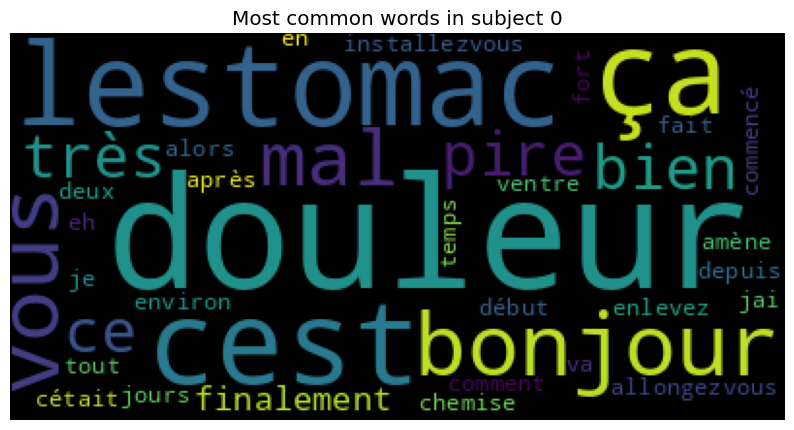

In [19]:
number_of_topics = topic_word.shape[0]
for i in range(number_of_topics):
    wordcloud(i)

In [20]:
def wordcloud(i):
    words_dist = topic_word[i, :]
    ranked_word_indices = words_dist.argsort()
    ranked_words = [tfidf_features[i] for i in ranked_word_indices][-1:-40:-1]
    ranked_words_in_one_text = " ".join(ranked_words)
    
    # Filter specific words    
    specific_words = ['anatomie', 'pelvien', 'périnée', 'vagin', 'vaginal', 'anus', 'rectal']
    filtered_words = [word for word in specific_words if word in ranked_words]
    
    if len(filtered_words) > 0:
        filtered_words_in_one_text = " ".join(filtered_words)
        cloud = WordCloud(background_color='black', colormap="viridis").generate(filtered_words_in_one_text)
        words = cloud.words_
        sorted_words = sorted(words, key=words.get, reverse=True)
        word_string = ", ".join(sorted_words)
        print(f"Words in word cloud : {word_string}")
    else:
        print(f"No specific words found in word cloud ")
  

In [21]:
number_of_topics = topic_word.shape[0]
for i in range(number_of_topics):
    wordcloud(i)

No specific words found in word cloud 
